In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import geopandas as gpd
from shapely import wkt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [152]:
# upload

intersection_intervention_ever_treated = pd.read_csv('../data/output/intersection_intervention_table_ever_treated_2015-2022.csv')

In [153]:
# pedestrian casualties in citywide intersections (background trend)

open_data_veh_collisions = pd.read_csv('../data/output/open-data_vehicle-collision-dataset.csv') 
open_data_veh_collisions['crash_date'] = pd.to_datetime(open_data_veh_collisions['crash_date'])
open_data_veh_collisions['pedestrian_death_or_injury'] = open_data_veh_collisions['number_of_pedestrians_killed'] + open_data_veh_collisions['number_of_pedestrians_injured']
open_data_veh_collisions[['pedestrian_death_or_injury']].groupby(open_data_veh_collisions['crash_date'].dt.year).sum().loc[2013:2024].plot()

<Axes: xlabel='year'>

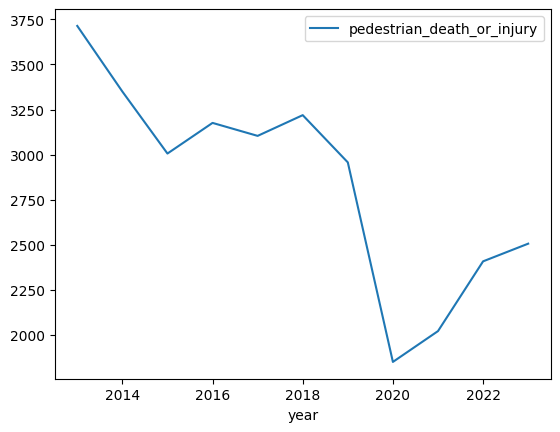

In [ ]:
# pedestrian casualties in treated intersections

intersection_intervention_ever_treated[['year','pedestrian_death_or_injury']].groupby('year').sum().loc[2013:2024].plot()

In [ ]:
# find when each intervention was first introduced to each intersection

intersection_interventions = ['leading_pedestrian_interval_post', 'turn_traffic_calming_post','slow_zones_post', 'enhanced_crossing_post', 'signal_retiming_post', 'speed_humps_post', 'street_improvement_project_post', 'street_improvement_corridors_post']

# melt the dataframe to create a long format for interventions
df_long = intersection_intervention_ever_treated.melt(
    id_vars=["year", "intersection_id"], 
    value_vars=intersection_interventions,
    var_name="intervention", 
    value_name="turned_on"
)

# filter only rows where interventions turned on
df_filtered = df_long[df_long["turned_on"] == 1]

# identify the first year each intervention was turned on for each intersection
inside_window_first_intervention = df_filtered.groupby(["intersection_id", "intervention"])["year"].min().reset_index()
# count how many intersections received each intervention for the first time per year
intersection_intervention_count = inside_window_first_intervention.groupby(["year", "intervention"]).size().unstack(fill_value=0).reset_index()
# find totals
intersection_intervention_count_table = intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count')
totals = intersection_intervention_count_table.sum().to_frame().T
totals.index = ["Total"]
intersection_intervention_count_table  = pd.concat([intersection_intervention_count_table, totals])
intersection_intervention_count_table

intervention,enhanced_crossing_post,leading_pedestrian_interval_post,signal_retiming_post,slow_zones_post,speed_humps_post,speed_limit_post,street_improvement_corridors_post,street_improvement_project_post,turn_traffic_calming_post
2014,0,0,0,0,0,9199,0,0,0
2015,15,74,254,344,192,0,562,17,0
2016,15,301,1530,55,216,0,650,17,39
2017,31,435,879,0,217,0,823,39,40
2018,20,382,671,0,271,0,640,52,52
2019,22,493,895,0,140,0,834,40,34
2020,4,341,558,0,11,0,590,11,29
2021,4,221,229,0,184,0,378,29,44
Total,111,2247,5016,399,1231,9199,4477,205,238


<Axes: xlabel='year'>

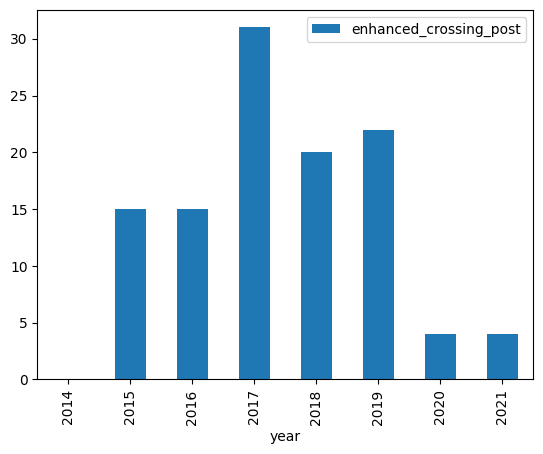

In [ ]:
# visualize spread

intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='enhanced_crossing_post', kind='bar')

<Axes: xlabel='year'>

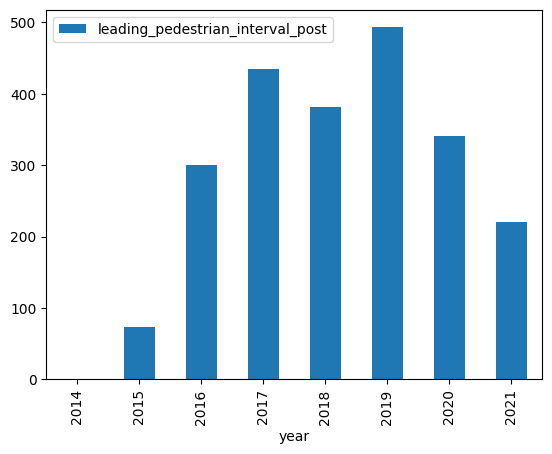

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='leading_pedestrian_interval_post', kind='bar')

<Axes: xlabel='year'>

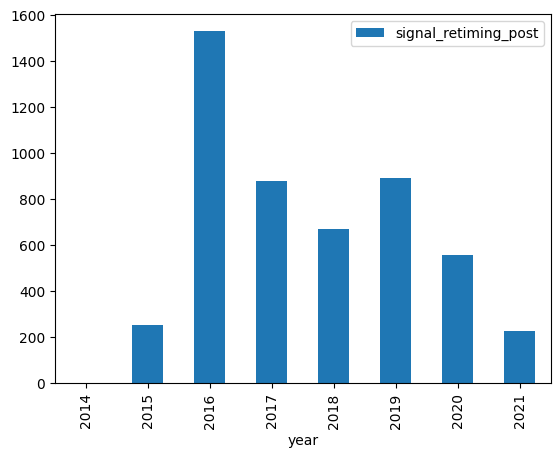

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='signal_retiming_post', kind='bar')

<Axes: xlabel='year'>

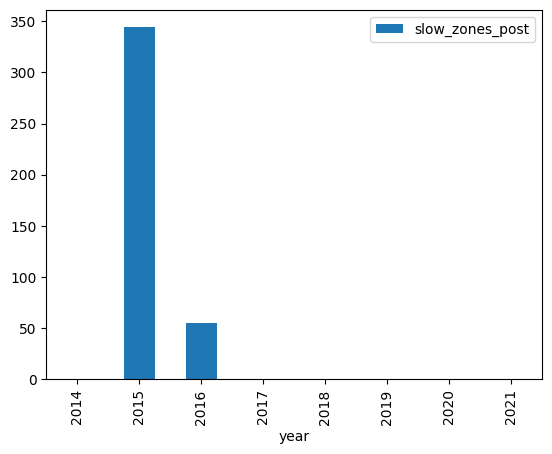

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='slow_zones_post', kind='bar')

<Axes: xlabel='year'>

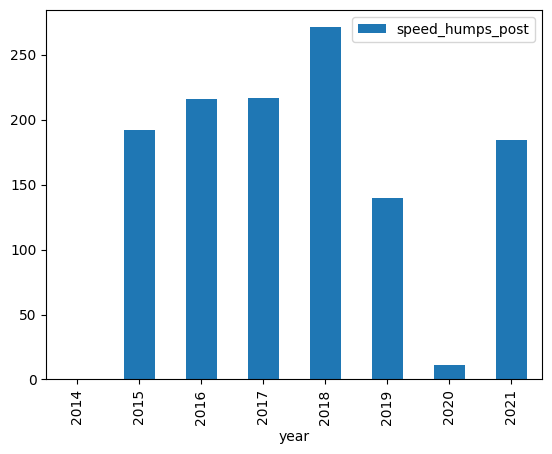

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='speed_humps_post', kind='bar')

<Axes: xlabel='year'>

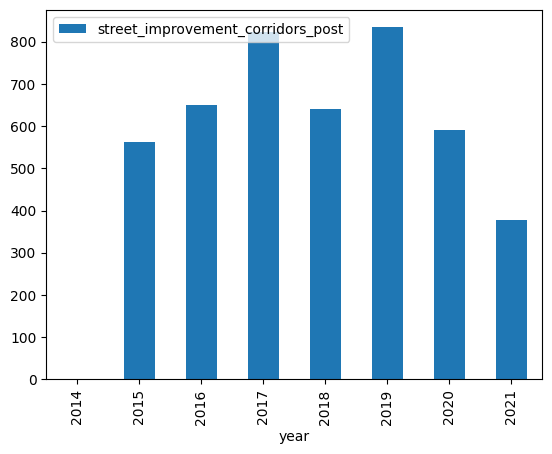

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='street_improvement_corridors_post', kind='bar')

<Axes: xlabel='year'>

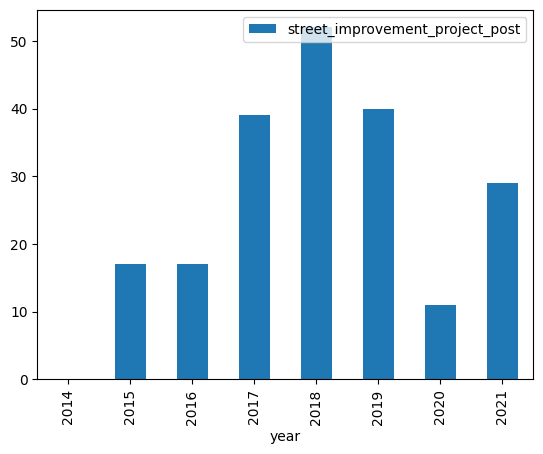

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='street_improvement_project_post', kind='bar')

<Axes: xlabel='year'>

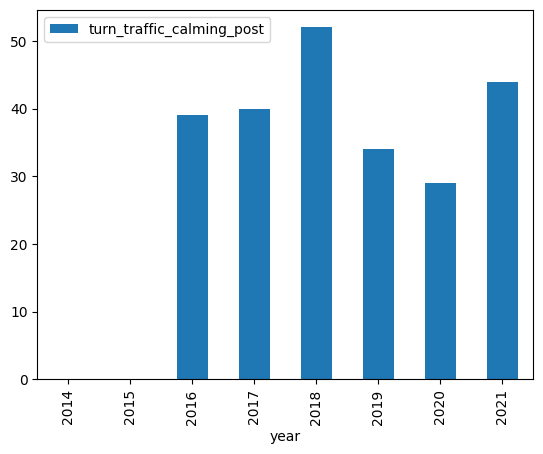

In [ ]:
intersection_intervention_count.groupby(intersection_intervention_count['year']).sum('count').plot(y='turn_traffic_calming_post', kind='bar')

In [ ]:
# creating table displaying proportion of each variable that is zero vs non-zero

# filter 
filtered_df = intersection_intervention_ever_treated[(intersection_intervention_ever_treated['year'].isin(list(range(2013,2024))))]

# select the relevant columns
selected_df = filtered_df[intersection_interventions]

# melt the dataframe into long format
melted_df = selected_df.melt(var_name="Intersection Intervention", value_name="value")

# count the occurrences of 0 and 1 for each intervention
count_table = (
    melted_df
    .value_counts(['Intersection Intervention', 'value'])
    .reset_index(name='count')
    .pivot(index='Intersection Intervention', columns='value', values='count')
    .fillna(0)  # Fill missing values with 0
    .rename(columns={0: 'Count_0', 1: 'Count_1'})
)

# calculate the percentage of non-zero values
count_table['Percent_Non_Zero'] = round((count_table['Count_1'] / (count_table['Count_0'] + count_table['Count_1'])) * 100, 2)

# sort by Percent_Non_Zero in ascending order
summary_table = count_table.reset_index()
summary_table = summary_table.sort_values(by='Percent_Non_Zero', ascending=True)

summary_table

value,Intersection Intervention,Count_0,Count_1,Percent_Non_Zero
0,enhanced_crossing_post,104386,730,0.69
7,street_improvement_project_post,103911,1205,1.15
8,turn_traffic_calming_post,103794,1322,1.26
3,slow_zones_post,101580,3536,3.36
4,speed_humps_post,97219,7897,7.51
1,leading_pedestrian_interval_post,92213,12903,12.28
6,street_improvement_corridors_post,77593,27523,26.18
2,signal_retiming_post,73017,32099,30.54
5,speed_limit_post,13126,91990,87.51


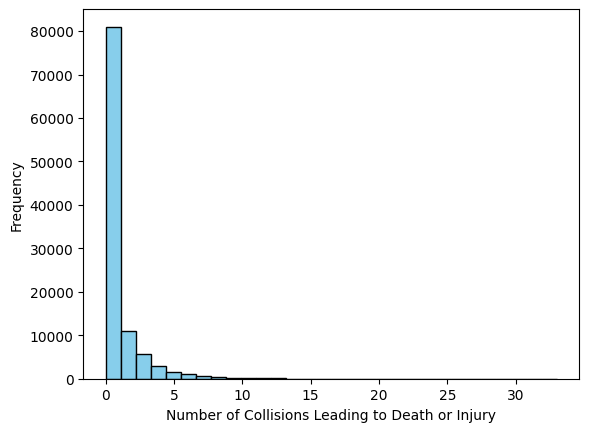

In [ ]:
# outcome variable distribution

plt.hist(intersection_intervention_ever_treated.set_index('year')[['total_death_or_injury']], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Number of Collisions Leading to Death or Injury')
plt.ylabel('Frequency')
 
plt.show()

In [ ]:
# most non-zero values are 1

intersection_intervention_ever_treated[intersection_intervention_ever_treated['total_death_or_injury'] > 0]['total_death_or_injury'].mode()

0    1.0
Name: total_death_or_injury, dtype: float64

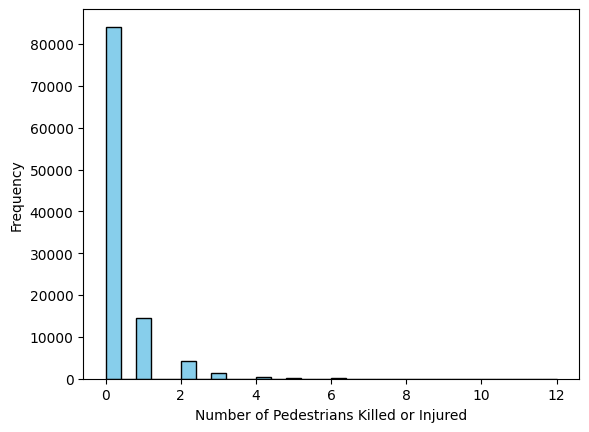

In [ ]:
# outcome variable distribution

plt.hist(intersection_intervention_ever_treated.set_index('year')[['pedestrian_death_or_injury']], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Number of Pedestrians Killed or Injured')
plt.ylabel('Frequency')
 
plt.show()

In [ ]:
# most non-zero values are 1

intersection_intervention_ever_treated[intersection_intervention_ever_treated['pedestrian_death_or_injury'] > 0]['pedestrian_death_or_injury'].mode()

0    1.0
Name: pedestrian_death_or_injury, dtype: float64

Number of intersections treated from 2015 through 2021: 2247


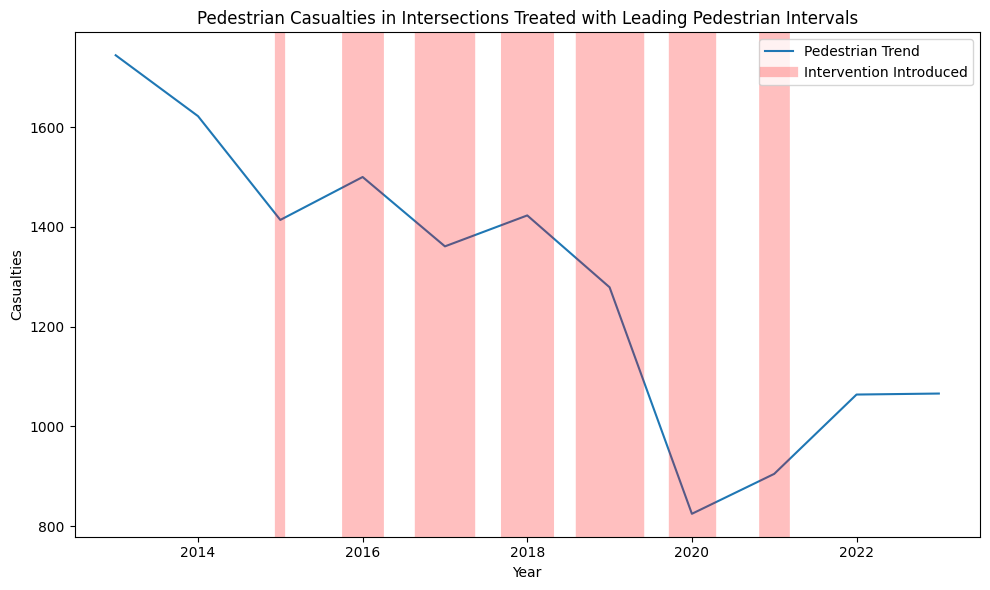

In [ ]:
# trend in collisions within intersections that received intervention
leading_pedestrian_interval_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['leading_pedestrian_interval_post'] == 1]['intersection_id'].unique()
leading_pedestrian_interval_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(leading_pedestrian_interval_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['leading_pedestrian_interval_post']].rename(columns={'leading_pedestrian_interval_post':'leading_pedestrian_interval_count'}).reset_index()

# plot of yearly trends
trend_df = leading_pedestrian_interval_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['leading_pedestrian_interval_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['leading_pedestrian_interval_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(leading_pedestrian_interval_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Leading Pedestrian Intervals')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 238


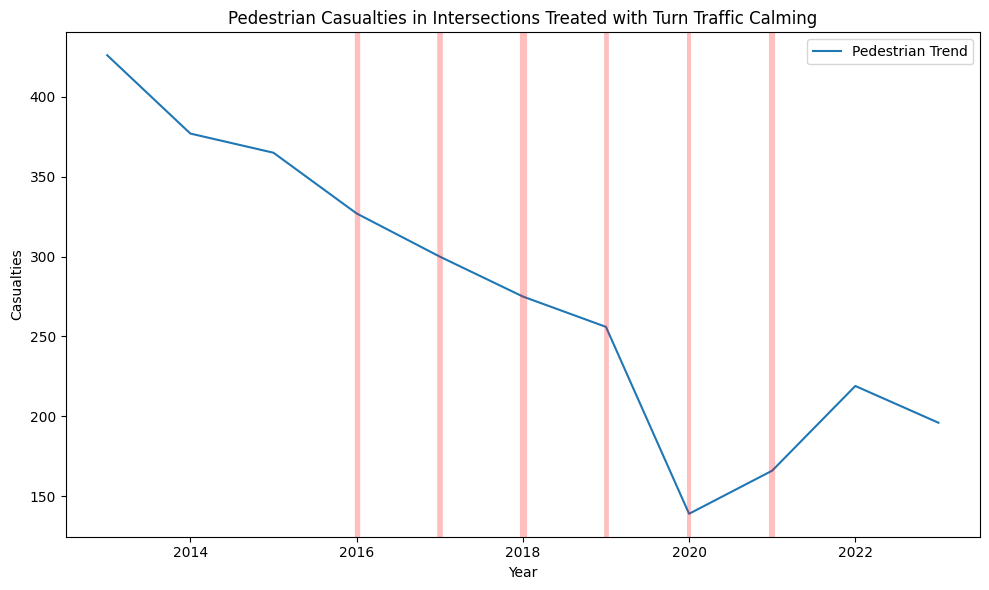

In [ ]:
# trend in collisions within intersections that received intervention
turn_traffic_calming_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['turn_traffic_calming_post'] == 1]['intersection_id'].unique()
turn_traffic_calming_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(turn_traffic_calming_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['turn_traffic_calming_post']].rename(columns={'turn_traffic_calming_post':'turn_traffic_calming_count'}).reset_index()

# plot of yearly trends
trend_df = turn_traffic_calming_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['turn_traffic_calming_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['turn_traffic_calming_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(turn_traffic_calming_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Turn Traffic Calming')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 399


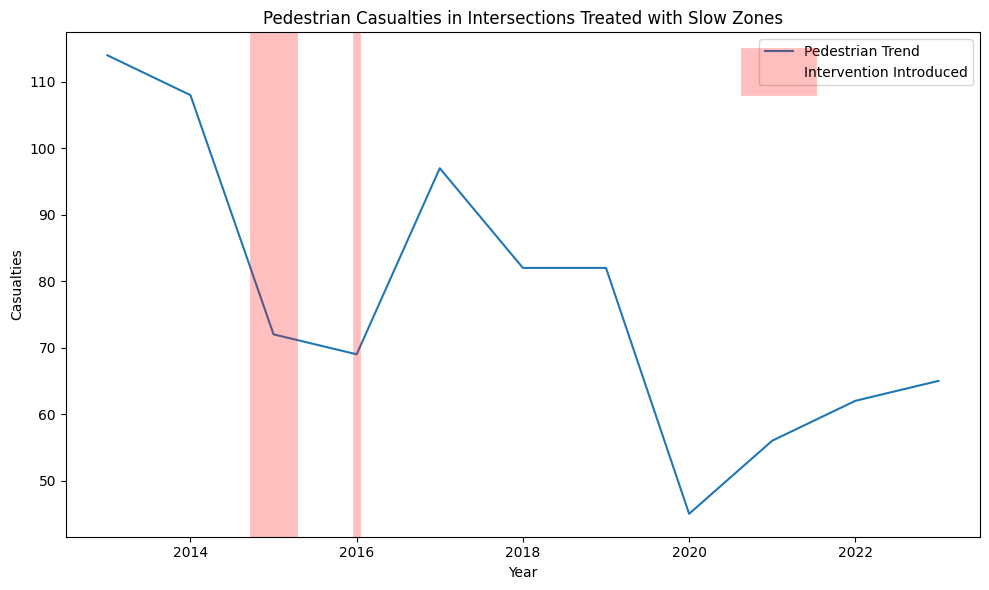

In [ ]:
# trend in collisions within intersections that received intervention
slow_zones_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['slow_zones_post'] == 1]['intersection_id'].unique()
slow_zones_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(slow_zones_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['slow_zones_post']].rename(columns={'slow_zones_post':'slow_zones_count'}).reset_index()

# plot of yearly trends
trend_df = slow_zones_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['slow_zones_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['slow_zones_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(slow_zones_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Slow Zones')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 113


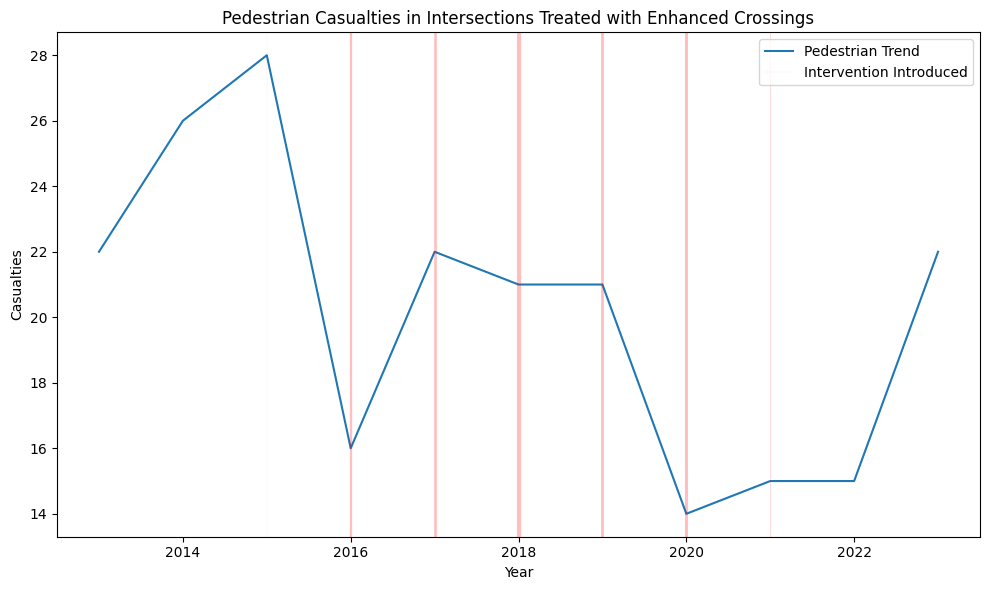

In [ ]:
# trend in collisions within intersections that received intervention
enhanced_crossing_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['enhanced_crossing_post'] == 1]['intersection_id'].unique()
enhanced_crossing_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(enhanced_crossing_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['enhanced_crossing_post']].rename(columns={'enhanced_crossing_post':'enhanced_crossing_count'}).reset_index()

# plot of yearly trends
trend_df = enhanced_crossing_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['enhanced_crossing_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['enhanced_crossing_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(enhanced_crossing_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Enhanced Crossings')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 5016


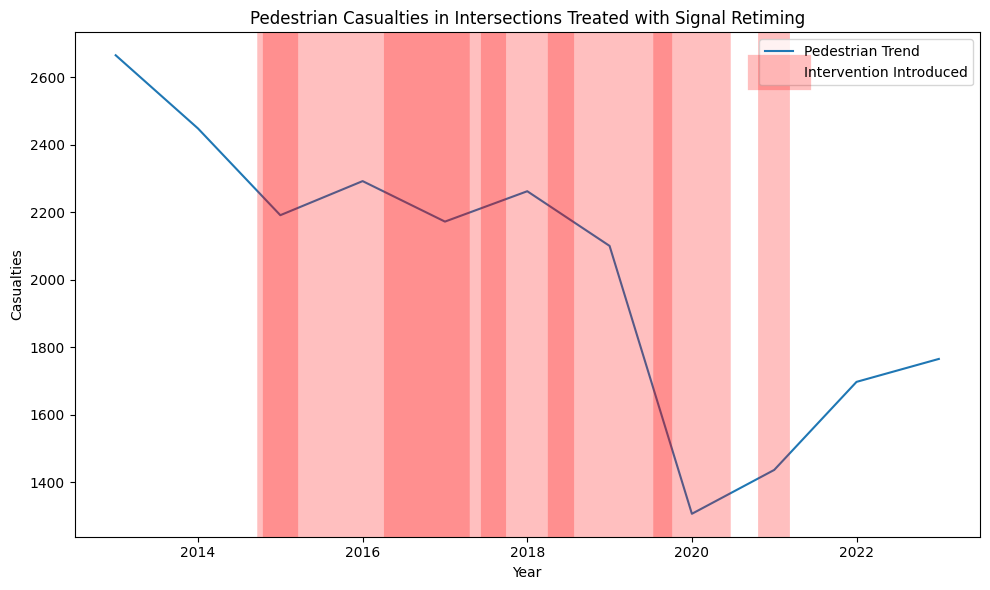

In [ ]:
# trend in collisions within intersections that received intervention
signal_retiming_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['signal_retiming_post'] == 1]['intersection_id'].unique()
signal_retiming_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(signal_retiming_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['signal_retiming_post']].rename(columns={'signal_retiming_post':'signal_retiming_count'}).reset_index()

# plot of yearly trends
trend_df = signal_retiming_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['signal_retiming_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['signal_retiming_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(signal_retiming_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Signal Retiming')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 1231


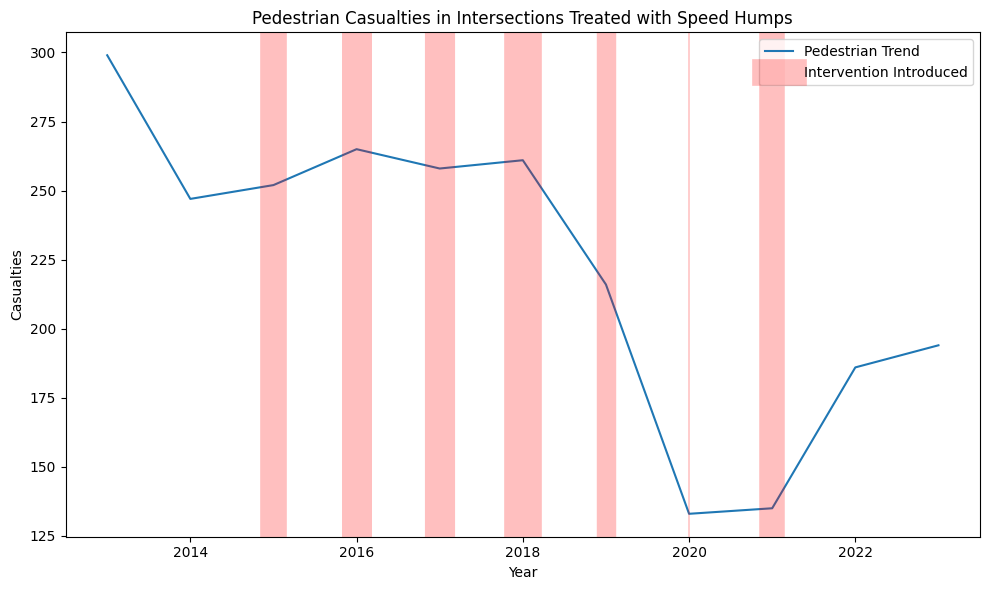

In [ ]:
# trend in collisions within intersections that received intervention
speed_humps_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['speed_humps_post'] == 1]['intersection_id'].unique()
speed_humps_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(speed_humps_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['speed_humps_post']].rename(columns={'speed_humps_post':'speed_humps_count'}).reset_index()

# plot of yearly trends
trend_df = speed_humps_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['speed_humps_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['speed_humps_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(speed_humps_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with Speed Humps')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 205


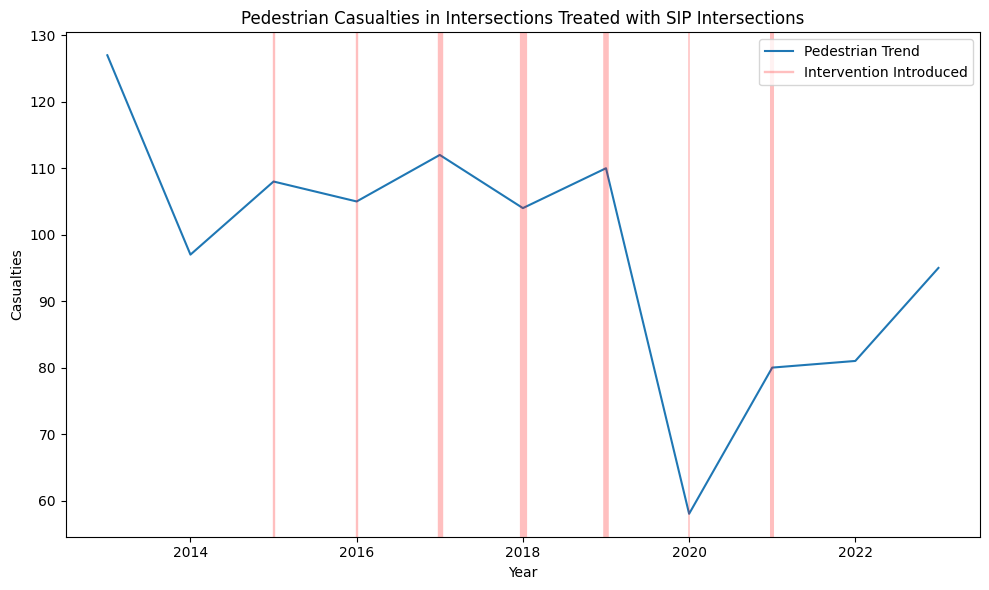

In [ ]:
# trend in collisions within intersections that received intervention
street_improvement_project_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['street_improvement_project_post'] == 1]['intersection_id'].unique()
street_improvement_project_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(street_improvement_project_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['street_improvement_project_post']].rename(columns={'street_improvement_project_post':'street_improvement_project_count'}).reset_index()

# plot of yearly trends
trend_df = street_improvement_project_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['street_improvement_project_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['street_improvement_project_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(street_improvement_project_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with SIP Intersections')
plt.legend()
plt.tight_layout()
plt.show()

Number of intersections treated from 2015 through 2021: 4477


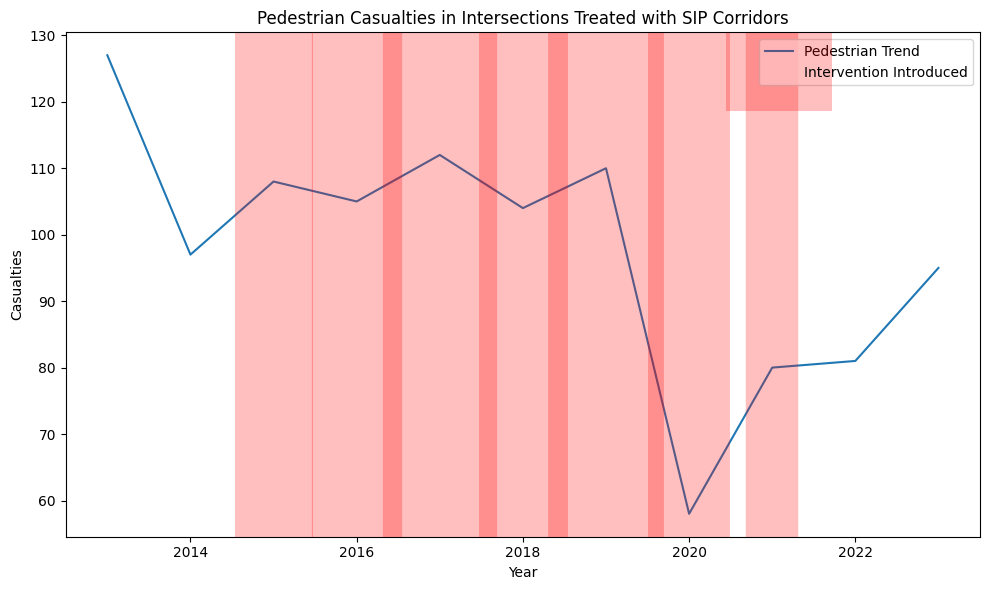

In [ ]:
# trend in collisions within intersections that received intervention
street_improvement_corridors_ids = intersection_intervention_ever_treated[intersection_intervention_ever_treated['street_improvement_corridors_post'] == 1]['intersection_id'].unique()
street_improvement_corridors_df = intersection_intervention_ever_treated[intersection_intervention_ever_treated['intersection_id'].isin(street_improvement_corridors_ids)]

# years when intervention introduced
lines_df = intersection_intervention_count.groupby('year').sum()[['street_improvement_corridors_post']].rename(columns={'street_improvement_corridors_post':'street_improvement_corridors_count'}).reset_index()

# plot of yearly trends
trend_df = street_improvement_project_df.groupby('year').sum()[['pedestrian_death_or_injury']].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(trend_df['year'], trend_df['pedestrian_death_or_injury'], label='Pedestrian Trend') 

# add vertical lines proportional to counts
for idx, row in lines_df.iterrows():
    if row['street_improvement_corridors_count'] > 0:  # only add lines for non-zero
        plt.axvline(
            x=row['year'],
            linewidth=row['street_improvement_corridors_count'] / 10,  # scale the thickness for better visibility
            color='red',
            alpha=0.25,
            label='Intervention Introduced' if idx == 0 else ""  
        )

print('Number of intersections treated from 2015 through 2021:', len(street_improvement_corridors_ids))

# add labels and legend
plt.xlabel('Year')
plt.ylabel('Casualties')
plt.title('Pedestrian Casualties in Intersections Treated with SIP Corridors')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# checking for multicollinearity
# VIFs should be below 5-10
# when remove nyc_metro_pop, collinearity issues go away

model_parameters = intersection_interventions + ['nyc_metro_pop', 'citywide_traffic_summonses', 'nyc_metro_dvmt', 'pop_per_sqmi','covid_2020', 'time']

X = add_constant(intersection_intervention_ever_treated[model_parameters]) 
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                             Variable            VIF
0                               const  481865.665925
1    leading_pedestrian_interval_post       1.243615
2           turn_traffic_calming_post       1.023891
3                     slow_zones_post       1.049547
4              enhanced_crossing_post       1.038333
5                signal_retiming_post       1.563107
6                    speed_humps_post       1.134432
7     street_improvement_project_post       1.034833
8   street_improvement_corridors_post       1.389793
9                       nyc_metro_pop      20.108738
10         citywide_traffic_summonses       1.306709
11                     nyc_metro_dvmt       5.491999
12                       pop_per_sqmi       1.064265
13                         covid_2020       2.936828
14                               time      25.656084


In [ ]:
# low variance variables
# identify variables with low variance (near zero)
variance = intersection_intervention_ever_treated[model_parameters].var()  

# threshold for near-zero variance
threshold = 0.01 

near_zero_variance_columns = variance[variance < threshold].index.tolist()
near_zero_variance_columns 

['enhanced_crossing_post']